# ML modelling on triangles - a Python example

Jacky Poon

Grainne McGuire

tags:
  - foundations
  - Python
  - lasso
  - gradient boosting
  - random forest
  - scikit-learn


# Introduction

In this article we look at applying different machine learning (ML) models to a data set. 
Our goal is to illustrate a work flow for:

-   setting up a data set for ML
-   applying different ML models to this data
-   tuning the ML hyper-parameters
-   comparing and contrasting performance for the past fitted values and the future predictions.

A secondary goal is to demonstrate the utility of a multi-model machine learning framework which enables the user to easily "plug and play" different machine learning models within the same framework. 

We use the **scikit-learn** in Python here. Followers of the blog may see significant similarities with the [earlier **mlr3** article for R users](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-mlr3example/), except this article uses Python.

You can download this notebook [here](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/f_notebooks/ML_triangles_example.ipynb) and run it on your local machine, or on a cloud service like Google Colab. If you are looking at such a downloaded copy, find the Machine Learning for Reserving blog [here](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/).

## Who is this article aimed at?

This article is aimed to Python users who know a little about some of the standard machine learning models, but who may not have done much hands-on analysis work. It will also be useful for those who have done some experimentation, but maybe not on a reserving data set. 

## Pre-requisites to this article

We've tried to make this article accessible to people new to ML, and to make this article stand-alone. Having some knowledge about basic machine learning techniques like decision trees, random forests and gradient boosting will help. Furthermore, we also fit the Chain Ladder model as a GLM (sometimes referred to as a Stochastic Chain Ladder) and fit a particular type of LASSO model. We've included limited details on these models here. Although our previous blog posts are in R, they have more details on the background of these:

* [Reserving with GLMs](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/glms/)
* [Self-assembling claim reserving models using the LASSO](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-lasso/)

We also fit some simple neural network models in this Python version.

## The data set

Our example deals with using ML to set reserves for a single aggregate 40x40 triangle. We've selected the data set because:

* It's small, so the code will run relatively quickly on your machine - there's nothing worse than running through a worked example and having to wait hours for results!
* A lot of reserving is still done using traditional accident (or underwriting) + development aggregated triangles so it is relevant to the real world.

We use a simulated data set. There are several reasons for this:

* We know the future results so can examine how different reserve predictions perform.
* We can control how the future experience emerges. In particular, we can ensure there are no future systemic changes (e.g. from legislation or court precedent) that would impact future payments. Changes like this can make it difficult when examining performance of reserve prediction methods on real data - it can be hard to separate poor performance of the model from a good model where the future experience departs markedly from that used to build the model.
* We can share the data set with you.

The data set used is simulated data set 3 from the paper [Self-assembling insurance claim models using regularized regression and machine learning](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906). This is a 40x40 triangle of incremental quarterly payments over 10 years. Variables on the data set are accident, development and calendar quarters only. A copy of the data set is available [here](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/lasso_simdata3.csv).

## Machine learning and aggregate triangles

Typically, ML and big data go hand-in-hand. By big data we mean lots of observations and lots of features (covariates / independent variables / regressors). Aggregate triangles are small in both senses - small numbers of observations and limited features (often just the 3 time features of accident/underwriting period, development period and calendar period).

This is not to say that it is invalid to use machine learning for aggregate triangles - many people have demonstrated good results from machine learning for such data - there are many papers on this topic. But it's also true that an experienced actuary using a Chainladder model (or other traditional) method, overlaid with judgement, will often get a similar answer to the best ML method, even for a complex triangle. However ML may be a more efficient way of getting to an answer. In the worked example below, we use a data set which deviates significantly from Chainladder assumptions. Therefore the unadjusted Chainladder projection is quite poor and would need a significant investment of time to yield a better model. In contrast, the better performing ML models we looked at have a better first estimate, so may not require as much intervention to produce a final estimate, thereby leading to a time-saving.

## Don't rank the ML models used based on this example

The purpose of this article is to demonstrate a workflow for fitting ML models in R. While we've done some work to improve model fitting, there are a lot more things we would consider if we were looking for the best models (e.g. feature engineering, train/test splits, performance measures). So, although we do look at the relative performance of the different models at the end, you should not make any conclusions about the relative performance of the different ML methods based on this work.

You may find that by adjusting some hyper-parameters, or by revising the training/test data set split, you're able to find better models. 
We'll be discussing this point a bit further at the end of the article.

*A priori*, given the form of the data (simulated using a regression style structure) and that the LASSO model we used is based on previous work which did aim to establish a framework to fit good models to triangular data using the LASSO, we expected that the LASSO model would perform the best and (spoiler alert!) it did.


## The scikit-learn package

One strength of using Python for machine learning is the consistency in input specifications for data. The Python community have generally coalesced onto **pandas** for data frames, **numpy** for matrices and **scikit-learn** for machine learning. 

The benefit of these is apparent - set up the data in the aggregator and then switch models in and out at will.

As a rough rule of thumb, when working with **scikit-learn** we:

* First set up an instance of the class. Note that the class can contain both methods (like functions) and data.
* We then run methods for the class object. These may update the data in the object.
* We can view and use the data in the class object. 

If you want to learn more there is plenty of documentation out there:

* The [scikit-learn website](https://scikit-learn.org/)
* Particularly, this [gallery of examples](https://scikit-learn.org/stable/auto_examples/index.html)
* [Cheatsheets](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf), with [explanations](https://www.datacamp.com/community/blog/scikit-learn-cheat-sheet)

When using Python code, your code editor may also display help and documentation (via "docstrings"). You can also get inline help by using the `help()` function on an object. This will bring you to help pages.

E.g. `import sklearn; help(sklearn)` with get you help on sklearn in general.

## ML methods used

We've looked at the following methods:

* Decision trees
* Random forests
* Gradient boosted machines (GBM) / gradient boosted decision trees
* Neural Networks (a basic one that comes with **scikit-learn**)
* Chainladder - or rather, a GLM which is set up to replicate the chain ladder estimates (refer to this [post](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/glms/) for more details)
* LASSO

# Outline of the workflow

The workflow we have set up consists of the following:

* Prepare the data for use in the models, including train and test partitions (past data) and hold-out or validation partitions (future data).
* Fit each of the models selected. For each of these we:
  + Select hyper-parameters (these control the model-fitting process) for tuning
  + Tune the hyper-parameters using the train and test partitions and select the set of values that yield the best results
  + Calculate predicted values on the holdout (future) data.
* Run diagnostics on the predicted values for each model and look at the reserve estimates.

We'll now work through each of the stages below.

# Setup

The first step is to import all the packages required for this work (and install them first if needed).

This session uses ``pandas``, ``numpy``, ``scikit-learn``, ``seaborn``, ``matplotlib`` and ``statsmodels``.

The versions are shown below. If you are having problems running our code, check that your packages are the same as ours and ``pip install -U`` upgrade / downgrade them if needed.

So let us get started with the example with some setup code.

In [1]:
!pip install -U scikit-learn

In [2]:
!pip show pandas numpy scikit-learn seaborn matplotlib

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /Users/Jacky/opt/miniconda3/lib/python3.9/site-packages
Requires: pytz, numpy, python-dateutil
Required-by: seaborn
---
Name: numpy
Version: 1.20.3
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Users/Jacky/opt/miniconda3/lib/python3.9/site-packages
Requires: 
Required-by: torchvision, tensorflow, tensorboard, seaborn, scipy, scikit-learn, pandas, opt-einsum, mkl-random, mkl-fft, matplotlib, Keras, Keras-Preprocessing, h5py
---
Name: scikit-learn
Version: 0.24.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Users/Jacky/opt/miniconda3/li

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import PoissonRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.utils import all_estimators

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import time

import itertools

# Set the seed for the random number generation so
# results are reproducible.
import random
random.seed(0)
np.random.seed(0)

# colours for plots - not all are used
# We will also use viridis for some plots
plot_colors = {
  "dblue"  : "#113458",
  "mblue"  : "#4096b8",
  "gold"   : "#d9ab16",
  "lgrey"  : "#dcddd9",
  "dgrey"  : "#3f4548",
  "black"  : "#3F4548",
  "red"    : "#d01e45",
  "purple" : "#8f4693",
  "orange" : "#ee741d",
  "fuscia" : "#e9458c",
  "violet" : "#8076cf"
}

# Data preparation

We're using a simulated data triangle with all values (past and future).

![past and future](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-07-mlr3example/index_files/figure-html/unnamed-chunk-3-1.png)

The data set we use is the simulated data set 3 from this [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906).
It is available in CSV form [here](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/lasso_simdata3.csv).

This is a 40x40 triangle of payments:

* That vary by accident quarter
* That vary by development quarter
* Have varying rates of superimposed inflation in payment size by calendar quarter (including no inflation)
* Have a step-up in payment size for accident quarters > 16 and development quarters > 20.

The first two effects are captured by a Chainladder model but the last two effects depart from Chainladder assumptions.

## The pandas package

We'll be using the **pandas** package for manipulating the data. There's an introduction to **pandas** on its [website](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) if you are unfamiliar with it.

## Load the data

First, load in the data and have a look at it.

In [4]:
# 1-4 will bring up different datasets. Covered in "next steps" note at the end of the article
dataset_number = 3

dat = pd.read_csv(
    f"https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/lasso_simdata{dataset_number}.csv",
    dtype={
        "pmts": np.float32,
        "acc": np.float32,
        "dev": np.float32,
        "cal": np.float32,
        "mu": np.float32,
        "train_ind": bool
    })

dat.head()

# create the num_periods variable - number of acc/dev periods
num_periods = int(dat["acc"].max())


As you can see, the data is not in triangular form as per the diagram above, but is instead in long form where:

* each row of the data set consists of one observation
* each observation has the accident(`acc`), development(`dev`) and calendar(`cal`) period associated with it
* the `mu` value is the mean value of the distribution from which `pmts` was simulated - this won't form part of the analysis below so can be ignored
* the final variable, `train_ind` is `TRUE` for past values and `FALSE` for future values.

This long format of data is standard for a lot of modelling and data analysis.

We can also show a visualisation of the data. This contains both past and future data (with a diagonal line marking the boundary). The plot uses shading to indicate the size of the payments (specifically, log(payments)).
The step-up in claim size (acc > 16 and dev > 20) is quite obvious in this graphic. What is also apparent is this this increase only affects a small part of the past triangle (10 cells out of 820 to be exact), but impacts much of the future lower triangle.

In [5]:
def plot_triangle(
    data, 
    mask_bottom=True, 
    title="Claims Development", 
    cmap=sns.color_palette("viridis_r", as_cmap=True), # Use Viridis colour palette just like the R code
    center=None,
    fig=None,
    ax=None):

    """ Plots a claims triangle heatmap
    data:
        Pandas DataFrame, indexed by date
    mask_bottom:
        Hide bottom half of triangle. Assumes origin and development periods
        are the same. e.g. both months
    cmap:
        Seaborn colour palette
    center:
        Centre for heatmap
    fig, ax: optional fig and ax
    """
    sns.set(style="white")

    # Generate a mask for the triangle
    if mask_bottom:
        mask = np.ones_like(data, dtype=bool)

        mask[np.tril_indices_from(mask)] = False

        mask = np.flipud(mask)
    else:
        mask = None

    # Set up the matplotlib figure
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    # Draw the heatmap with the mask and correct aspect ratio vmax=.3,
    sns.heatmap(
        data,
        mask=mask,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        fmt=".0f",
        cbar_kws={"shrink": 0.5},
        norm=LogNorm()  # Log scale
    ).set_title(title)

    return fig, ax


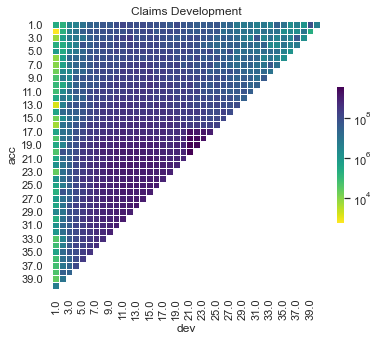

In [6]:
# Partial triangle - the model only sees this for training
plot_triangle(
    dat.pivot(index="acc", columns="dev", values="pmts"),
    mask_bottom=True
)

plt.show()

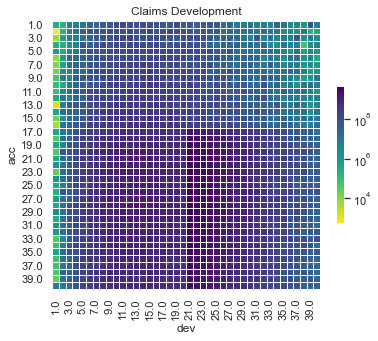

In [7]:
# Whole triangle - with test dataset
plot_triangle(
    dat.pivot(index="acc", columns="dev", values="pmts"),
    mask_bottom=False
)

plt.show()

The step-up in payments can be modelled as an interaction between accident and development quarters.
Because it affects only a small number of past values, it may be difficult for some of the modelling approaches to capture this.
It's likely, therefore, that the main differentiator between the performance of different methods for this data set will be how much well they capture this interaction.

One thing to note is that the Chainladder will struggle with this data set. Both the calendar period terms and the interaction are not effects that the Chainladder can model - it assumes that only accident and development period main effects (i.e. no interactions) are present. So an actuary using the Chainladder for this data set would need to overlay judgement to obtain a good result.

We need to modify this data a little before proceeding further and add factor versions (essentially a categorical version) of acc and dev - these are needed later for fitting the Chainladder.

In [8]:
# Factors with zero index
dat["accf"] = (dat.acc - 1).astype(int)
dat["devf"] = (dat.dev - 1).astype(int)

## Train and Test

In [9]:
X_train = (dat.loc[dat.train_ind, ["acc", "dev", "cal", "accf", "devf"]])
y_train = (dat.loc[dat.train_ind, "pmts"])

X_test = (dat.loc[dat.train_ind == False, ["acc", "dev", "cal", "accf", "devf"]])
y_test = (dat.loc[dat.train_ind == False, "pmts"])

X = (dat.loc[:, ["acc", "dev", "cal", "accf", "devf"]])
y = (dat.loc[:, "pmts"])

# Tuning process for hyper-parameters

Machine learning models have a number of hyper-parameters that control the model fit.
Tweaking the hyper-parameters that control model fitting (e.g. for decision trees, the depth of the tree, or for random forests, the number of trees to average over) can have a significant impact on the quality of the fit. 
The standard way of doing this is to use a train and test data set where:

* The model is trained (built) on the train data set
* The performance of the model is evaluated on the test data set
* This is repeated for a number of different combinations of hyper-parameters, and the best performing one is selected.

Evaluating the models on a separate data set not used in the model fitting helps to control over-fitting.
Usually we would then select the hyper-parameters that lead to the best results on the test data set and use these to predict our future values.

There are various ways we can select the test and train data sets.
For this work we use cross-validation. We'll give a brief overview of it below. 
Note that we will be discussing validation options in a separate article. 


## Cross-validation

The simplest implementation of a train and test partition is a random one where each point in the data set is allocated to train and test at random.
Typically, the train part might be around 70-80% of the data and the test part the remainder.


**Random test data set**

![random test dataset](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-07-mlr3example/index_files/figure-html/unnamed-chunk-13-1.png)

Cross-validation repeats this type of split a number of times.

In more detail, the steps are:

* Randomly partition the data into *k* equal-sized folds (between 5-10 folds are common choices). These folds are then fixed for the remainder of the algorithm. 
* Fit the model using data from *k*-1 of the folds, using the remaining fold as the test data. Do this *k* times, so each fold is used as test data once.
* Calculate the performance metrics for each model on the corresponding test fold.
* Average the performance metrics across all the folds.

A simplified representation of the process is given below. 

**5-fold cross validation**

![n-fold CV](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-07-mlr3example/index_files/figure-html/unnamed-chunk-14-1.png)

Cross-validation provides an estimate of out-of-sample performance even though all the data is used for training and testing. 
It is often considered more robust due to its use of the full dataset for testing, but can be computationally expensive for larger datasets. Here we only have a small amount of data, so there is an advantage to using the full dataset, whilst the computational cost is manageable. 

## Cross-validation in scikit-learn

We will be setting up cross-validation resamplers in scikit-learn to apply to our models and find optimal hyper-parameters. As always, the documentation for [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html), [grid search CV](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) and [random search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are useful starting reference point.

Here we will use 6-fold cross validation. As applied to our triangles, it will look something like this, where the yellow points are the training data and the blue the test data in each fold:

![6-fold-on-triangle](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-07-mlr3example/index_files/figure-html/unnamed-chunk-17-1.png)


## Performance measure

During the cross-validation process, we need to have a performance measure to optimise.

Here we will use RMSE (root mean square error).

## Searching hyper-parameter space

Searching hyper-parameter space needs to be customised to each model, so we can't set up a common framework here. However, to control computations, it is useful to set a limit on the number of searches that can be performed in a tuning exercise.

Given how we set up the tuning process below we need 25 evaluations for the decision tree and random forest models. We need many more evaluations for the GBM model since we tune more parameters. However, this can take a long time to run. In practice, using a more powerful computer, or running things in parallel can help.

So we've set the number of evaluations to a low number here (25). 

# Fitting some ML models

Now it's time to fit and tune the following ML models using **scikit-learn**:

* Decision tree 
* Random forest
* Gradient boosting machines (GBM)
* Neural Network

## Decision tree

A decision tree is unlikely to be a very good model for this data, and tuning often doesn't help much.
Nonetheless, it's a simple model, so it's useful to fit it to see what happens.

To illustrate the use of scikit-learn, we'll first show how to fit a model using the default hyper-parameters.
We'll then move onto the code needed to run hyper-parameter tuning using cross-validation.

### Fitting a single model

First let's fit a simple decision tree.

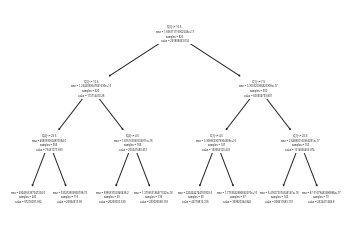

In [10]:
dtree = DecisionTreeRegressor(max_depth=3)
dtree.fit(X_train, y_train)

plot_tree(dtree)

plt.show()

Unfortunately this plot is too small to read. If you are unfamiliar with decision tree diagrams, then these diagrams give splitting rules for the data. At the terminal nodes, predicted values for each segment are given. If you are able to read this plot (e.g. you are running the Jupyter notebook), then 


Here's a list of the parameters - [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) will have more information.

In [11]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Let's try tuning the `max_depth` and 'ccp_alpha' parameters.


### Tuning the decision tree

To set up the tuning we need to specify:

* The ranges of values to search over
* A resampling strategy (already have this - crossvalidation)
* An evaluation measure (this is RMSE)
* A termination criterion so searches don't go on for ever (our `evals_trm`)
* The search strategy (e.g. grid search, random search, etc - see, e.g., [this post](https://towardsdatascience.com/hyperparameter-tuning-a-practical-guide-and-template-b3bf0504f095) )

We first set ranges of values to consider for these:
 * ``criterion``: whether to fit on the basis of ``mse`` which aligns with our evaluation metric or ``poisson`` to match the log-link GLMs later in the piece
 * ``max_depth``: how big the trees can be,
 * ``ccp_alpha``: complexity parameter for pruning.

In [12]:
parameters_tree = {
    "criterion": ["mse", "poisson"],
    "max_depth": [2, 3, 5, 7, None], # None is unlimited depth.
    "ccp_alpha": [0.0, 0.2, 0.4, 0.6, 0.8]
}

5 of each of ``max_depth`` and ``ccp_alpha`` for a 2x5x5 grid. Given we only have 50 points, we can easily evaluate every option so we'll use a grid search strategy.

In practice other search strategies may be preferable - e.g. a random search often gets similar results to a grid search, in a much smaller amount of time.
Another possible choice is Bayesian optimisation search.

So now we have everything we need to tune our hyper-parameters so we can set this up with **GridSearchCV** now.

In [13]:
grid_tree = GridSearchCV(DecisionTreeRegressor(), parameters_tree)
grid_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [0.0, 0.2, 0.4, 0.6, 0.8],
                         'criterion': ['mse', 'poisson'],
                         'max_depth': [2, 3, 5, 7, None]})

The parameters in the best fit may be accessed here:

In [14]:
grid_tree.best_estimator_.get_params()

{'ccp_alpha': 0.8,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

These also fit a final model to the data using these optimised parameters.

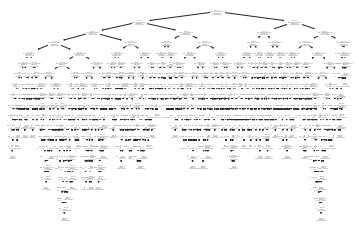

In [15]:
# plot the model
plot_tree(grid_tree.best_estimator_)

plt.show()

This model is much more complicated than the original and looks overfitted - we'll see if this is the case when we evaluate the model performance later in the article. 


## Random forest fitting

The random forest model for regression is `sklearn.ensemble.RandomForestRegressor`.

Let's have a look at the hyper-parameters.

In [16]:
rforest = RandomForestRegressor()
rforest.fit(X_train, y_train)

rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Here, we'll try tuning `max_depth` and 'ccp_alpha' parameters again. 

We'll follow the same steps as for decision trees - set up a parameter space for searching, combine this with RMSE and cross-validation, tune using grid search, and get the best fit.

In [17]:
parameters_forest = {
    "max_depth": [2, 3, 5, 7, None], # None is unlimited depth.
    "ccp_alpha": [0.0, 0.2, 0.4, 0.6, 0.8],
    "random_state": [0]
}

grid_forest = GridSearchCV(
    RandomForestRegressor(), 
    parameters_forest,  
    n_jobs=-1)

grid_forest.fit(X_train, y_train)
grid_forest.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

## GBM

There are two GBM implementations in **scikit-learn**. The first is `sklearn.ensemble.GradientBoostingRegressor` which implements a "traditional" GBM. 

The other is `sklearn.ensemble.HistGradientBoostingRegressor` which implements a number of performance tricks to speed up model fitting, similar to `LightGBM` or the fast histogram method in `XGBoost`. This is considered an experimental feature with the `scikit-learn` version we are using. 

Here are the GBM parameters.


In [18]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)

gbm.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

With gradient boosting, it is often helpful to optimise over hyper-parameters, so we will vary some parameters and select the best performing set.

For speed reasons we will just consider `n_estimators`, `learning_rate`, `max_depth` , and `subsample` but in practice, we could consider doing more.

The steps are the generally same as before for decision trees and random forests. However as we are searching over a greater number of parameters, we've switched to a random search to try to achieve better results.

Depending on your computer, this step takes a while to run since we are running the slower GradientBoostingRegressor - even though we have a low `n_iter` - so it might be a good point to grab a cup of coffee or tea! 


In [19]:
parameters_gbm = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [1, 2, 3, 5, 6],
    "learning_rate": [0.01, 0.02, 0.05, 0.1, 0.3],
    "subsample": [0.5, 0.7, 1.0]
}

In [20]:
tic = time.perf_counter()

grid_gbm = RandomizedSearchCV(
    GradientBoostingRegressor(), 
    parameters_gbm, 
    n_iter=25, 
    n_jobs=-1, # Run in parallel
    random_state=0
)

grid_gbm.fit(X_train, y_train)

toc = time.perf_counter()
print(f"Ran in {toc - tic:0.4f} seconds")

Ran in 7.4581 seconds


In [21]:
# Get the best fit:
grid_gbm.best_estimator_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'ls',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 0.5,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

However, remember that these results are from 25 evaluations only, and with 4 hyper-parameters, we'd really like to use more evaluations. The model above isn't a particularly good one.

Next, the HistGradientBooster which is most similar to LightGBM, which was in turn based on XGBoost. It's quite possible to install those packages too to include more full featured models but to make this tutorial code easy to install and use, we won't introduce the extra dependencies and just use the scikit-learn implementation:


In [22]:
parameters_hgbm = {
    "loss": ["least_squares", "poisson"],
    "max_iter": [100, 200, 300, 400, 500],
    "max_depth": [1, 2, 3, 5, 6],
    "learning_rate": [0.01, 0.02, 0.05, 0.1, 0.3]
}

In [23]:
tic = time.perf_counter()
# This regressor is generally quite fast so we can run a few more.
grid_hgbm = RandomizedSearchCV(
    HistGradientBoostingRegressor(), 
    parameters_hgbm, 
    n_iter=100, 
    n_jobs=-1, # Run in parallel
    random_state=0
)

grid_hgbm.fit(X_train, y_train)

toc = time.perf_counter()
print(f"Ran in {toc - tic:0.4f} seconds")
# It was not faster in this case with this dataset.

Ran in 38.4765 seconds


In [24]:
# Get the best fit:
grid_hgbm.best_estimator_.get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'poisson',
 'max_bins': 255,
 'max_depth': 6,
 'max_iter': 400,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In the R code, we mentioned a previously tuned XGBoost model with hyperparameters tuned over a larger search. Can we replicate the model in Python here?

In [25]:
gbm_prev = HistGradientBoostingRegressor(
    loss='poisson',  # Poisson is close to Tweedie with variance power 1.01
    max_iter=233,
    learning_rate=0.3,
    max_depth=3
)

gbm_prev.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.3, loss='poisson', max_depth=3,
                              max_iter=233)

## Neural Network

Neural networks - also known as deep learning models - are models based on interconnected neurons which take in inputs, apply a function and produce outputs used by other neurons, ultimately to predict response variables. 

In the **R** article with **mlr3** we skipped neural networks as these required keras which can be a little tricky to install. However, **scikit-learn** includes a simple [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) model so we will try that here. 

This is a simple feedforward model where each layer is connected in order. 

![Feedforward model diagram](https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif)

[Source: Wikipedia](https://en.wikipedia.org/wiki/Feedforward_neural_network#/media/File:Feed_forward_neural_net.gif)

Unlike the diagram all neurons are just simply connected to all neurons in the following layer. But there are many variations on how those neurons can be connected which we may explore in future articles.

With the features, we will transform accident, development and calendar periods with one-hot encoding to treat them as continuous variables, and let the model figure the rest out. With the target, given the average value is approx $300m, we'll scale it so the model can hopefully find convergence faster - and we will try a few different learning rates.

In [26]:
parameters_nn = {
    "hidden_layer_sizes": [ 
        # Keep these to 50 neurons to keep things small
        # (We do only have 3 factors)
        (50,),           # single hidden layer
        (25, 25),         # two layers
        (16, 16, 16),     # three layers
        (12, 12, 12, 12), # four layers
        (30, 15, 5),     # bottleneck model - reduce data to 10 final effects
    ],
    "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    # Activation: Relu is standard but logistic / sigmoid has been used by some
    # researchers in reserving applications
    "activation": ["logistic", "relu"], 
    "random_state": [0],
    "max_iter": [200000]  # More iterations worked well for lasso model in R
}

col_transformer_nn = ColumnTransformer(
    [
        ('zero_to_one', MinMaxScaler(), ["acc", "dev", "cal"])
    ],
    remainder='drop'
)

In [27]:
tic = time.perf_counter()
neural_network = Pipeline(
    steps=[
        ('transform', col_transformer_nn), 
        ('nn', TransformedTargetRegressor(
                regressor=RandomizedSearchCV(
                  MLPRegressor(),
                  parameters_nn, 
                  n_jobs=-1, # Run in parallel
                  n_iter=25, # Models train slowly, so try only a few models
                  random_state=0),
                # An output activation function of exp would have been nice
                # But not available in scikit, so we will fit on log-transformed 
                # values and exponentiate.
                func=lambda x: np.log(x / y_train.mean()), 
                inverse_func=lambda x: np.exp(x) * y_train.mean(),
                check_inverse=False))
    ]
)

neural_network.fit(X_train, y_train)
toc = time.perf_counter()
print(f"Ran in {toc - tic:0.4f} seconds")

Ran in 86.3401 seconds


In [28]:
neural_network["nn"].regressor_.best_estimator_.get_params()

{'activation': 'relu',
 'alpha': 1e-05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (12, 12, 12, 12),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Before we do any analysis, let's fit a couple more models to compare these results against:

* a Chainladder model
* a LASSO model


## Chainladder - the baseline model

Since this is a traditional triangle, it seems natural to compare any results to the Chainladder result. So here, we will get the predicted values and reserve estimate for the Chainladder model.

It's important to note that we will just use a volume-all Chainladder (i.e. include all periods in the estimation of the development factors) and will not attempt to impose any judgement over the results. In practice, of course, models like the Chainladder are often subject to additional analysis, reasonableness tests and manual assumption selections, so it's likely the actual result would be different, perhaps significantly, from that returned here.

At the same time, no model, whether it be the Chainladder, or a more sophisticated ML model should be accepted without further testing, so on that basis, comparing Chainladder and ML results without modification is a reasonable thing to do. Better methods should require less human intervention to return a reasonable result.


### Getting the Chainladder reserve estimates

The Chainladder reserve can also be calculated using a GLM with:

* Accident and development factors
* The Poisson or over-dispersed Poisson distribution
* The log link.

We've used this method here as it's easy to set up in Python but practical work using the Chainladder may be better done with a package like the [Python Chainladder package](https://chainladder-python.readthedocs.io/en/latest/) by CASact.

The easiest way to do this is to use [Pipelines](https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines) which allows us to have a neat package of a model that comes with its own data transformations - specifically to use `accf` and `devf` properly. 

Here's the code using `PoissonRegressor` and the `predict()` method to add predicted values into `model_forecasts`. 

In [29]:
col_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(), ["accf", "devf"])], 
    remainder='drop'
)

# PoissonRegressor gives a log-link GLM. But need to set alpha=0 so it is not a LASSO.
chain_ladder = Pipeline(
    steps=[
        ('transform', col_transformer), 
        ('glm', PoissonRegressor(alpha=0, max_iter=5000))
    ]
)

chain_ladder.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('encoder', OneHotEncoder(),
                                                  ['accf', 'devf'])])),
                ('glm', PoissonRegressor(alpha=0, max_iter=5000))])

## LASSO (regularised regression)

Finally, we will use the LASSO to fit a model. We are going to fit the same model as we did in our previous [post](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-lasso/). We'll include a bare-bones description of the model here. If you haven't seen it before, then you may want to just take the model as given and skip ahead to the next section. Once you've read this entire article you may then wish to read the post on the LASSO model to understand the specifics of this model.

The main things to note about this model are:

* Feature engineering is needed to produce continuous functions of accident / development / calendar quarters for the LASSO to fit.
* The blog post and related paper detail how to do this - essentially we create a large group of basis functions from the primary `acc`, `dev` and `cal` variables that are flexible enough to capture a wide variety of shapes.
* We need to create a model that contains these basis functions as features.
* We then need to fit and predict using the values for a particular penalty setting (the regularisation parameter) - following the paper, we use the penalty value that leads to the lowest cross-validation error.

### Basis functions

The first step is to create all the basis functions that we need. The functions below create the ramp and step functions needed (over 4000 of these!). The end result is a data.table of the original payments and all the basis functions. As noted above, all the details are in the blog post and paper.

In [30]:
def LinearSpline(var, start, stop):
    """
    Linear spline function - used in data generation and in spline generation below
    """
    return np.minimum(stop - start, np.maximum(0, var - start))


def GetScaling(vec):
    """
    Function to calculate scaling factors for the basis functions
    scaling is discussed in the paper
    """
    fn = len(vec)
    fm = np.mean(vec)
    fc = vec - fm  

    return  ((np.sum(fc**2))/fn)**0.5


def GetRamps(vec, vecname, nperiods, scaling):
    """
    Function to create the ramps for a particular primary vector
    vec = fundamental regressor
    vecname = name of regressor
    np = number of periods
    scaling = scaling factor to use
    """
    df = pd.DataFrame.from_dict(
        {
            f"L_{i}_999_{vecname}": LinearSpline(vec, i, 999) / scaling
            for i in range(1, nperiods)
        }
    )
    return df


def GetInts(vec1, vec2, vecname1, vecname2, nperiods, scaling1, scaling2, train_ind):
    """
    Create the step (heaviside) function interactions.
    f"I_{vecname1}_ge_{i}xI_{vecname2}_ge_{j}" formats the name of the column
    LinearSpline(vec1, 1, i+1) / scaling1 * LinearSpline(vec2, j, j + 1) / scaling2
    is the interaction term
    and we loop over all combinations of 1:nperiods and 2:nperiods
    """
    
    vecs = {}
    for i, j in itertools.product(*[range(2, nperiods), range(2, nperiods)]):
        interaction = (
            LinearSpline(vec1, i - 1, i) / scaling1 * 
            LinearSpline(vec2, j - 1, j) / scaling2
        )

        # Only include if non-constant over training data
        if not np.all(interaction[train_ind] == interaction[0]):
            vecs[f"I_{vecname1}_ge_{i}xI_{vecname2}_ge_{j}"] = interaction

    df = pd.DataFrame.from_dict(vecs)
    return df

Now the functions are defined, we'll create a data.table of basis functions here which we'll use later when fitting the LASSO.
The `dat_plus` table will hold them.

In [31]:
# get the scaling values
rho_factor_list = {
    v: GetScaling(dat.loc[dat.train_ind, v].values) 
    for v in ["acc", "dev", "cal"]
}

rho_factor_list

{'acc': 9.539392014169456, 'dev': 9.539392014169456, 'cal': 9.539392014169456}

In [32]:
# main effects - matrix of values
main_effects_acc = GetRamps(vec = dat["acc"], vecname = "acc", nperiods = num_periods, scaling = rho_factor_list["acc"])
main_effects_dev = GetRamps(vec = dat["dev"], vecname = "dev", nperiods = num_periods, scaling = rho_factor_list["dev"])
main_effects_cal = GetRamps(vec = dat["cal"], vecname = "cal", nperiods = num_periods, scaling = rho_factor_list["cal"])

main_effects = pd.concat([main_effects_acc, main_effects_dev, main_effects_cal], axis="columns")

``main_effects`` looks like this:

In [33]:
main_effects

,L_1_999_acc,L_2_999_acc,L_3_999_acc,L_4_999_acc,L_5_999_acc,L_6_999_acc,L_7_999_acc,L_8_999_acc,L_9_999_acc,L_10_999_acc,...,L_30_999_cal,L_31_999_cal,L_32_999_cal,L_33_999_cal,L_34_999_cal,L_35_999_cal,L_36_999_cal,L_37_999_cal,L_38_999_cal,L_39_999_cal
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,4.088311,3.983482,3.878654,3.773825,3.668997,3.564168,3.45934,3.354511,3.249683,3.144854,...,4.717281,4.612453,4.507625,4.402796,4.297967,4.193139,4.088311,3.983482,3.878654,3.773825
1596,4.088311,3.983482,3.878654,3.773825,3.668997,3.564168,3.45934,3.354511,3.249683,3.144854,...,4.822110,4.717281,4.612453,4.507625,4.402796,4.297967,4.193139,4.088311,3.983482,3.878654
1597,4.088311,3.983482,3.878654,3.773825,3.668997,3.564168,3.45934,3.354511,3.249683,3.144854,...,4.926939,4.822110,4.717281,4.612453,4.507625,4.402796,4.297967,4.193139,4.088311,3.983482
1598,4.088311,3.983482,3.878654,3.773825,3.668997,3.564168,3.45934,3.354511,3.249683,3.144854,...,5.031767,4.926939,4.822110,4.717281,4.612453,4.507625,4.402796,4.297967,4.193139,4.088311


In [34]:
# Export to file for debugging
# main_effects.to_csv("main_effects_py.csv")

In [35]:
# interaction effects
int_effects = pd.concat([
    GetInts(vec1=dat["acc"], vecname1="acc", scaling1=rho_factor_list["acc"],  
            vec2=dat["dev"], vecname2="dev", scaling2=rho_factor_list["dev"], 
            nperiods=num_periods, train_ind=dat["train_ind"]),

    GetInts(vec1=dat["dev"], vecname1="dev", scaling1=rho_factor_list["dev"],  
            vec2=dat["cal"], vecname2="cal", scaling2=rho_factor_list["cal"], 
            nperiods=num_periods, train_ind=dat["train_ind"]),
    
    GetInts(vec1=dat["acc"], vecname1="acc", scaling1=rho_factor_list["acc"],  
            vec2=dat["cal"], vecname2="cal", scaling2=rho_factor_list["cal"], 
            nperiods=num_periods, train_ind=dat["train_ind"])
    ], 
    axis="columns")

The table looks like this:

In [36]:
int_effects

,I_acc_ge_2xI_dev_ge_2,I_acc_ge_2xI_dev_ge_3,I_acc_ge_2xI_dev_ge_4,I_acc_ge_2xI_dev_ge_5,I_acc_ge_2xI_dev_ge_6,I_acc_ge_2xI_dev_ge_7,I_acc_ge_2xI_dev_ge_8,I_acc_ge_2xI_dev_ge_9,I_acc_ge_2xI_dev_ge_10,I_acc_ge_2xI_dev_ge_11,...,I_acc_ge_39xI_cal_ge_30,I_acc_ge_39xI_cal_ge_31,I_acc_ge_39xI_cal_ge_32,I_acc_ge_39xI_cal_ge_33,I_acc_ge_39xI_cal_ge_34,I_acc_ge_39xI_cal_ge_35,I_acc_ge_39xI_cal_ge_36,I_acc_ge_39xI_cal_ge_37,I_acc_ge_39xI_cal_ge_38,I_acc_ge_39xI_cal_ge_39
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989
1596,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989
1597,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989
1598,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989


In [37]:
# Export to file for debugging
# int_effects.to_csv("int_effects_py.csv")

In [38]:
varset = pd.concat([main_effects, int_effects], axis="columns")
varset_train = varset.loc[dat.train_ind]

# drop any constant columns over the training data set
# do this by identifying the constant columns and dropping them
keep_cols = (varset != varset.iloc[0]).any()

varset = varset.loc[:, keep_cols] 
varset_train = varset_train.loc[:, keep_cols]

# now add these variables into an extended data object
# remove anything not used in modelling
dat_plus =  pd.concat(
    [
        dat[["pmts", "train_ind"]], 
        varset
    ], 
    axis="columns")

### Setup for LASSO

First we need to set up the data for the model. This differs from the tree-based models task as follows in that the input variables are all the basis functions we created and not the raw accident / development / calendar quarter terms - the `dat_plus` data.table.


In [39]:
X_train_plus = varset[dat.train_ind]
X_test_plus = varset.loc[dat.train_ind == False]
X_plus = varset

### DIY GLMnet with Pytorch

The results will not be identical to those in the paper since the Python implementation is different and uses different hyper-parameters.

We want to use GLM with LASSO regularization and CV, but at the time of writing, the implementation in ``scikit-learn`` has major limitations. 

The [PoissonRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html) does not have "warm restarts" which allows re-using the coefficients as it tests through different regularisation factors, so CV is slow. More importantly, its ``alpha`` regularization parameter is a l2 ridge regression penalty, not the l1 LASSO penalty.

As far as alternatives go, the following are unlikely to meet our needs:

 * ``statsmodels`` seemed incredibly slow in our early experiments, taking over a day to train a single model on this data.
 * ``pyglmnet`` also seemed incredibly slow.
 * ``glmnet_py`` requires Linux. It should in theory run via [Google Colab](https://colab.research.google.com/) or [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10) as well, but for this particular tutorial we wanted to share a multi-platform solution.
 * ``python-glmnet`` only implements linear and logistic regression.

Our options seem to be using the cluster computing framework [h2o.ai](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html) or creating our own LASSO using a neural network framework like **pytorch**. 

Both seem a little overkill but, but since we're planning to cover more on neural networks in future articles, we can use **pytorch** to introduce some concepts here.

Firstly we will just import pytorch. If you are running this on your pc and have a GPU you would like to utilise, make sure you [install the right version for best performance](https://pytorch.org/get-started/locally/).

In [40]:
import torch
import torch.nn as nn
from torch.distributions import Normal, OneHotCategorical
import torch.nn.functional as F

torch.manual_seed(0)

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

First we will create a **Pytorch Module** for the GLM. This is pretty straightforward - a neural network with no hidden layers is a LM, and by applying an exponential to the output, we have a log-link GLM.

In [41]:
class LogLinkGLM(nn.Module):
    # Define the parameters in __init__
    def __init__(
        self, 
        n_input=3): # number of inputs

        
        super(LogLinkGLM, self).__init__()
        
        
        self.linear = torch.nn.Linear(n_input, 1)  # These will be the coefficients
        nn.init.zeros_(self.linear.weight)         # Initialise these to zero


    # forward defines how you get y from X.
    def forward(self, x):
        return torch.exp(self.linear(x))  # log(Y) = XB -> Y = exp(XB)


Next, to fit it within our **scikit-learn** framework, we will make a **scikit-learn** Regressor. The key components are:

 * ``__init__``: Define any hyperparameters here. At a minimum, this would include the lasso regularization penalty.

 * ``fit``: Define the training process for the model. For ``pytorch`` we have a training loop where we read data, calculated the loss, backpropogate it and update the weights.

 * ``predict``: Define how to get predictions - i.e. apply the ``forward`` method of the Module.

 * ``score``: Define performance. Here we will use RMSE for consistency with the notebook.

There is also some added boilerplate about getting data into the right format.


In [42]:
class LogLinkGLMNetRegressor(BaseEstimator, RegressorMixin):

    def __init__(
        self, 
        l1_penalty=0.0,          # lambda is a reserved word
        weight_decay=0.0,
        max_iter=200000,
        lr=0.01,
        min_improvement=0.01,
        check_improvement_every_iter=5000,
        patience=3,
        init_weight=None,
        init_bias=None,
        verbose=1,
        target_device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")):
        """ Log Link GLM LASSO Regressor

        This trains a GLM with Poisson loss, Log Link and l1 LASSO penalties
        using Pytorch. It has early stopping 

        Note:
            Do not include the `self` parameter in the ``Args`` section.

        Args:
            l1_penalty (float): l1 penalty factor (we use l1_penalty because lambda is
                a reserved word in Python for anonymous functions)

            weight_decay (float): weight decay - analogous to l2 penalty factor
            
            max_iter (int): Maximum number of epochs before training stops

            lr (float): Learning rate

            min_improvement (float), patience (int), check_improvement_every_iter (int): 
                RMSE must improve by this percent otherwise patience will decrement. 
                Once patience reaches zero, training stops.

            verbose (int): 0 means don't print. 1 means do print.

            init_weight, init_bias (torch tensor): initial weight (coefficient) 
                and bias (intercept) for a warm start. 
        """
        self.l1_penalty = l1_penalty
        self.weight_decay = weight_decay
        self.max_iter = max_iter
        self.target_device = target_device
        self.min_improvement = min_improvement
        self.lr = lr
        self.patience = patience
        self.init_weight = init_weight
        self.init_bias = init_bias
        self.check_improvement_every_iter = check_improvement_every_iter
        self.verbose = verbose

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Skorch is picky about format
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(X.astype(np.float32)).to(self.target_device)
        y_tensor = torch.from_numpy(y.astype(np.float32)).reshape(-1, 1).to(self.target_device)

        n_input = X.shape[-1]
        self.module_ = LogLinkGLM(n_input=n_input).to(self.target_device)

        # Set initial weight
        if self.init_weight is not None:
            self.module_.linear.weight.data = self.init_weight

        # Set initial intercept 
        if self.init_bias is not None:
            self.module_.linear.bias.data = self.init_bias
        else:
            # To something close so gradients do not explode
            avg_log_y = np.log(np.mean(y))
            self.module_.linear.bias.data = torch.tensor([avg_log_y])

        optimizer = torch.optim.AdamW(
            params=self.module_.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        loss_fn = nn.PoissonNLLLoss(log_input=False).to(self.target_device)

        last_rmse = -1
        patience = self.patience

        # Training loop
        for epoch in range(self.max_iter):        # Repeat max_iter times
            y_pred = self.module_(X_tensor)  # Apply current model
            loss = loss_fn(y_pred, y_tensor) # What is the loss on it?
            loss += self.l1_penalty * self.module_.linear.weight.abs().sum()  # lasso        
            optimizer.zero_grad()            # Reset optimizer
            loss.backward()                  # Apply back propagation
            optimizer.step()                 # Update model parameters

            # Every 5,000 steps (or setting) get RMSE 
            if epoch % self.check_improvement_every_iter == 0:   
                rmse = torch.sqrt(torch.mean(torch.square(y_pred - y_tensor)))

                if self.verbose > 0:
                    print("Train RMSE: ", rmse.data.tolist())    # Print loss

                # Stop if not 
                if rmse.data.tolist() > last_rmse * (1 - self.min_improvement):
                    patience += -1
                
                if patience == 0:
                    if self.verbose > 0:
                        print("Insufficient improvement found, stopping training")
                    break

                last_rmse = rmse.data.tolist()

        # Return the regressor
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        # Skorch is picky about format
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values     

        # Convert to Pytorch Tensor
        X_tensor = torch.from_numpy(X.astype(np.float32)).to(self.target_device)

        # Apply current model and return
        return self.module_(X_tensor).cpu().detach().numpy().ravel()


    def score(self, X, y):
        # Negative RMSE score (higher needs to be better)
        y_pred = self.predict(X)
        return -np.sqrt(np.mean((y_pred - y)**2))

### Previous best fit

So, can we replicate the previously tuned model from R in Python?

In [43]:
tic = time.perf_counter()

lasso_prev = LogLinkGLMNetRegressor(l1_penalty=7674)
lasso_prev.fit(X_train_plus, y_train)

toc = time.perf_counter()
print(f"Ran in {toc - tic:0.4f} seconds")

Train RMSE:  428498688.0
Train RMSE:  53182680.0
Train RMSE:  52894192.0
Train RMSE:  48454752.0
Train RMSE:  47999504.0
Insufficient improvement found, stopping training
Ran in 64.2999 seconds


### Cross Validation

With our new Regressor we can now do CV with something that resembles warm starts by putting an initial fit (here we will recycle the previous best GLM from R) as the starting weights for the search.

The key parameter to tune in lasso is the regularisation penalty. With **glmnet** in R and in most academic literature, this is typically called ``lambda``. However, with scikit-learn in Python, with ``lambda`` being a reserved keyword for anonymous functions, we will call the same parameter ``l1_penalty``.

With our DIY "semi warm start" the training is faster but still takes a while. To keep a reasonable running time for running the example we will keep it to ten runs near the optimal lambda from the R run, but if we were building the model from scratch we would be testing many more values of lambda.

If running time is a critical factor and it is taking too long, three considerations:
 1. **pytorch** runs faster with a GPU, 
 2. You can get much smarter with the warm start logic.
 3. You can also consider the GLM implementation in the h2o.ai package mentioned earlier which is quite fast.

In [44]:
lambdas = [np.exp(0.1 * x) for x in range(86, 96)]
lambdas

[5431.659591362978,
 6002.912217261029,
 6634.24400627789,
 7331.973539155995,
 8103.083927575384,
 8955.292703482508,
 9897.129058743927,
 10938.019208165191,
 12088.380730216988,
 13359.726829661873]

In [45]:
parameters_lasso = {
    "l1_penalty": lambdas, 
    "init_weight": [lasso_prev.module_.linear.weight.data],
    "init_bias": [lasso_prev.module_.linear.bias.data],
    "lr": [0.001], # Fine tuning?
    "check_improvement_every_iter": [100], 
    "verbose": [0]
}

In [46]:
tic = time.perf_counter()

# N.b. this will not run in parallel.
lasso = GridSearchCV(
    LogLinkGLMNetRegressor(), 
    parameters_lasso, 
    verbose=1)

lasso.fit(X_train_plus, y_train)
toc = time.perf_counter()
print(f"Ran in {toc - tic:0.4f} seconds")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Ran in 34.7665 seconds


Let's plot the test error vs different regularisation parameters:


<AxesSubplot:xlabel='log(lambda)'>

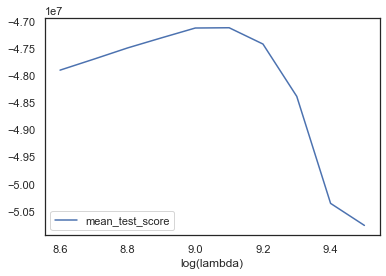

In [47]:
# Check the path includes a minimum value of error
pd.DataFrame({
  "log(lambda)": [np.log(p["l1_penalty"]) for p in lasso.cv_results_["params"]],
  "mean_test_score": lasso.cv_results_["mean_test_score"]
}).plot(x="log(lambda)", y="mean_test_score")

In [48]:
print("Best regularisation parameter [log(lambda)] was:") 
print(np.log(lasso.best_estimator_.get_params()["l1_penalty"]))

Best regularisation parameter [log(lambda)] was:
9.1


In [49]:
# Get the best fit:
lasso.best_estimator_.get_params()

{'check_improvement_every_iter': 100,
 'init_bias': tensor([15.3488]),
 'init_weight': tensor([[-1.1317e+00, -8.1524e-01, -5.3453e-01,  ...,  1.3915e-04,
           1.3895e-04,  1.3895e-04]]),
 'l1_penalty': 8955.292703482508,
 'lr': 0.001,
 'max_iter': 200000,
 'min_improvement': 0.01,
 'patience': 3,
 'target_device': device(type='cpu'),
 'verbose': 0,
 'weight_decay': 0.0}

We arrive back at the original value of ``lambda``.

# Model analysis

This is the interesting bit - let's look at all the models to see how they've performed (but remember not to draw too many conclusions about model performance from this example as discussed earlier!).

## Consolidate results

Now we will consolidate results for these models. We will gather together:

* RMSE for past and future data
* predictions for each model.

Note that **scikit-learn** has various tuning tools which we haven't used here yet - partially because we want to focus on the concepts rather than the code and partially because we want to compare the results to a couple of other models not fitted in the same framework. If you're interested in learning more then the section on [tuning](https://scikit-learn.org/stable/modules/grid_search.html) in the documentation is a good start. 

First, we'll set up a data frame to hold the model projections for each model and populate these projections for each model

In [50]:
# Dataset of all forecasts
model_forecasts = dat.copy()
model_forecasts["Decision Tree"] = grid_tree.best_estimator_.predict(X)
model_forecasts["Random Forest"] = grid_forest.best_estimator_.predict(X)
model_forecasts["Classic GBM"] = grid_gbm.best_estimator_.predict(X)
model_forecasts["Histogram GBM"] = grid_hgbm.best_estimator_.predict(X)
model_forecasts["Hist GBM (prev)"] = gbm_prev.predict(X)
model_forecasts["Neural Network"] = neural_network.predict(X)
model_forecasts["Chain Ladder"] = chain_ladder.predict(X)
model_forecasts["LASSO"] = lasso.predict(X_plus)
model_forecasts["LASSO (prev)"] = lasso_prev.predict(X_plus)

Here's how our collated forecast DataFrame looks so far:

In [51]:
model_forecasts

,pmts,acc,dev,cal,mu,train_ind,accf,devf,Decision Tree,Random Forest,Classic GBM,Histogram GBM,Hist GBM (prev),Neural Network,Chain Ladder,LASSO,LASSO (prev)
0,2.426712e+05,1.0,1.0,1.0,7.165313e+04,True,0,0,2.426712e+05,1.887456e+05,6.014116e+06,3.500558e+04,4.569216e+04,2.034437e+04,3.585367e+04,4633215.0,4641892.5
1,1.640013e+05,1.0,2.0,2.0,1.042776e+06,True,0,1,1.640013e+05,2.087371e+05,6.072307e+06,5.235618e+05,7.127655e+05,2.364422e+05,1.234291e+06,5844869.0,5853403.5
2,3.224478e+06,1.0,3.0,3.0,4.362600e+06,True,0,2,3.224478e+06,3.578825e+06,6.259892e+06,2.676693e+06,2.217522e+06,2.121035e+06,3.324359e+06,8970644.0,8977765.0
3,3.682531e+06,1.0,4.0,4.0,1.095567e+07,True,0,3,3.682531e+06,5.627768e+06,9.945203e+06,5.691426e+06,5.253524e+06,4.810498e+06,8.746143e+06,15132947.0,15134997.0
4,1.014937e+07,1.0,5.0,5.0,2.080055e+07,True,0,4,1.014937e+07,1.605141e+07,2.417595e+07,1.582105e+07,1.564311e+07,1.021459e+07,1.715827e+07,24922094.0,24914536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.265737e+07,40.0,36.0,75.0,8.285330e+07,False,39,35,3.276252e+09,3.088414e+09,2.819504e+09,3.895124e+08,3.132752e+08,1.119816e+08,2.794976e+08,155724928.0,140357952.0
1596,6.346768e+07,40.0,37.0,76.0,6.268272e+07,False,39,36,3.276252e+09,3.088414e+09,2.819504e+09,3.895124e+08,3.132752e+08,1.005221e+08,1.896219e+09,200310144.0,182843872.0
1597,2.604198e+07,40.0,38.0,77.0,4.722784e+07,False,39,37,3.276252e+09,3.088414e+09,2.819504e+09,3.895124e+08,3.132752e+08,9.023538e+07,4.350021e+08,257674688.0,238155184.0
1598,3.394727e+07,40.0,39.0,78.0,3.544488e+07,False,39,38,3.276252e+09,3.088414e+09,2.819504e+09,3.895124e+08,3.132752e+08,8.100099e+07,5.732754e+09,331492544.0,310216256.0


## RMSE

We are going to do these calculations by using the **scikit-learn** benchmark tools. Since the LASSO model is the only one using the **plus** datasets, we will use that as the starting example

In [52]:
# Empty list to store results.
scikit_results = []
y_predicted_full_results = {}
y_predicted_test_results = {"Actuals": y_test}

In [53]:
# LASSO uses the "plus" datasets
# Train:
y_predicted_train = lasso.predict(X_train_plus)
train_rmse = mean_squared_error(y_train, y_predicted_train, squared=False)

# Test:
y_predicted_test = lasso.predict(X_test_plus)
test_rmse = mean_squared_error(y_test, y_predicted_test, squared=False)

# Append to the list of results.
y_predicted_full_results["LASSO"] = lasso.predict(X_plus)
y_predicted_test_results["LASSO"] = y_predicted_test

scikit_results += [{
    "Name": "LASSO", 
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse
}]

In [54]:
# LASSO (prev) also uses the "plus" datasets
# Train:
y_predicted_train = lasso_prev.predict(X_train_plus)
train_rmse = mean_squared_error(y_train, y_predicted_train, squared=False)

# Test:
y_predicted_test = lasso_prev.predict(X_test_plus)
test_rmse = mean_squared_error(y_test, y_predicted_test, squared=False)

# Append to the list of results.
y_predicted_full_results["LASSO (prev)"] = lasso_prev.predict(X_plus)
y_predicted_test_results["LASSO (prev)"] = y_predicted_test

scikit_results += [{
    "Name": "LASSO (prev)", 
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse
}]

and then for the rest we put it in a loop running on the **"non-plussed"** datasets:

In [55]:
# Using zip in a for loop means pipe and name will run through 
# the tuples of the two lists in that order.
for pipe, name in zip(
        [grid_tree.best_estimator_, grid_forest.best_estimator_, grid_gbm.best_estimator_, 
         grid_hgbm.best_estimator_, gbm_prev, neural_network, chain_ladder],
        ["Decision Tree", "Random Forest", "Classic GBM", "Histogram GBM", "Hist GBM (prev)", "Neural Network", "Chain Ladder"]
    ):

    y_predicted_train = pipe.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_predicted_train, squared=False)

    y_predicted_test = pipe.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_predicted_test, squared=False)

    y_predicted_full_results[name] = pipe.predict(X)
    y_predicted_test_results[name] = y_predicted_test

    scikit_results += [{
    "Name": name, 
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse
    }]

Let's have a look at these results for past and future data sets with results ranked by test RMSE.


In [56]:
df_results = pd.DataFrame(scikit_results).sort_values("Test RMSE")

In [57]:
pd.set_option('display.float_format', '{0:,.0f}'.format)
display(df_results)

,Name,Train RMSE,Test RMSE
0,LASSO,"48,283,020","252,009,808"
1,LASSO (prev),"49,082,112","269,974,336"
6,Hist GBM (prev),"40,110,165","313,377,932"
5,Histogram GBM,"34,464,022","455,524,543"
7,Neural Network,"274,930,720","930,978,112"
4,Classic GBM,"42,979,008","1,603,949,161"
8,Chain Ladder,"138,528,934","1,722,351,650"
3,Random Forest,"30,698,739","1,789,873,775"
2,Decision Tree,0,"1,916,509,816"


The key indicator is performance on a hold-out data set, in this case the future data. Otherwise, looking at Train RMSE, the decision tree would be perfect, having overfit the data to a loss of zero. 

For the future data, we see a very different story. As expected, the tuned decision tree does appear to be over-fitted, performing the worst. 

The LASSO model performs the best. The CV tuned model is pretty similar to the previous model from the R run.

The histogram GBM model follows. The "previously tuned" version has essentially identical performance to the XGBoost model from the R version of this article.

The simple neural network follows that. 

## Visualising the fit

Although useful, the RMSE is just a single number so it's helpful to visualise the fit.
In particular, because these are models for a reserving data set, we can take advantage of that structure when analysing how well each model is performing.

### Fitted values

First, lets show visualise the fitted payments.
The graphs below show the log(fitted values), or log(payments) in the case of the actual values.

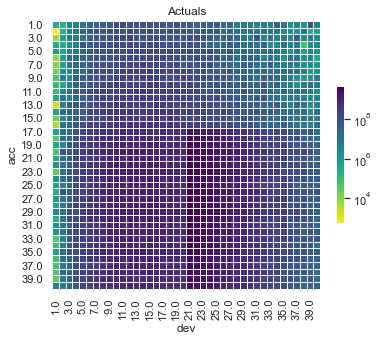

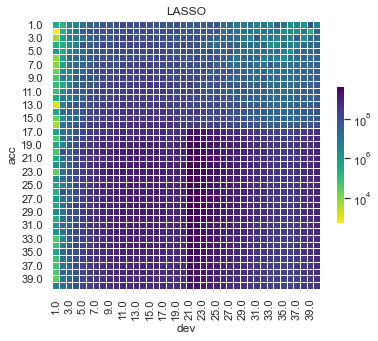

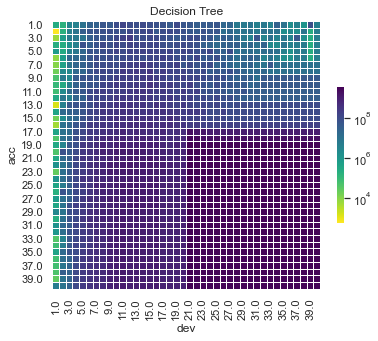

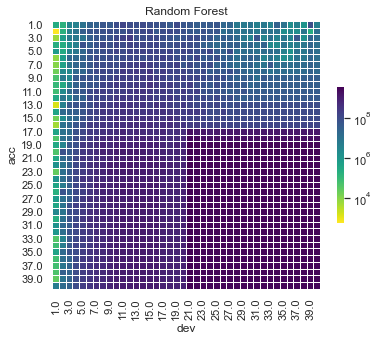

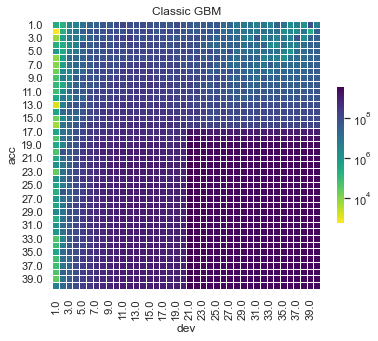

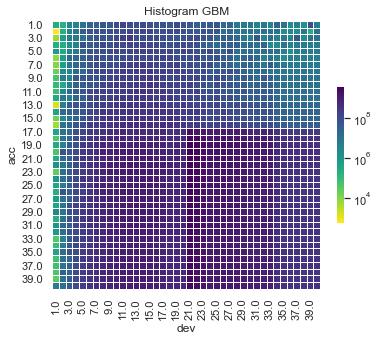

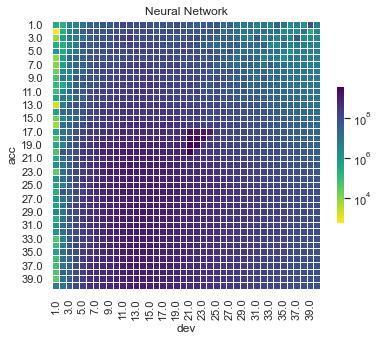

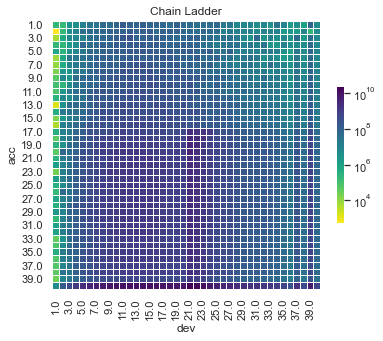

In [58]:
for name, y_pred in y_predicted_test_results.items():
    # Skip prev models - these are similar enough to last version
    if name not in ["LASSO (prev)", "Hist GBM (prev)"]:  
        # Plot
        dat_ = dat.copy() 
        dat_.loc[dat_.train_ind == False, "pmts"] = y_pred
        
        plot_triangle(
            dat_.pivot(index="acc", columns="dev", values="pmts"),
            mask_bottom=False,
            title=name
        )

plt.show()

Some things are apparent from this:

* The lack of interactions or diagonal effects in the Chain ladder
* All the machine learning models do detect and project the interaction
* The blocky nature of the decision tree and the overfit to the past data
* The random forest and GBMs fit look smoother since they are a function of a number of trees.
* The LASSO and neural network fits are the smoothest, which is not surprising since it consists of continuous functions.
* Visually, the LASSO seems to capture the interaction the best.


### Actual vs Fitted heat maps

We can also look at the model fits via heat maps of the actual/fitted values.

For triangular reserving data, these types of plots are very helpful when examining plot fit.

First, here's a function to draw the heatmaps.



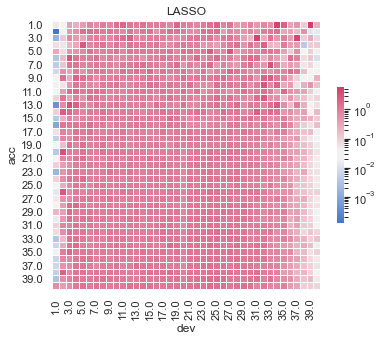

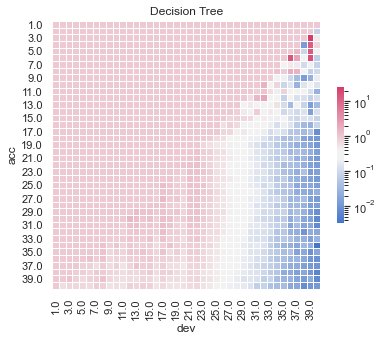

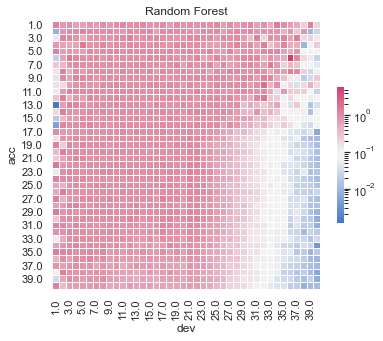

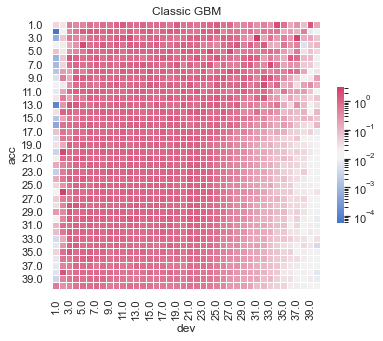

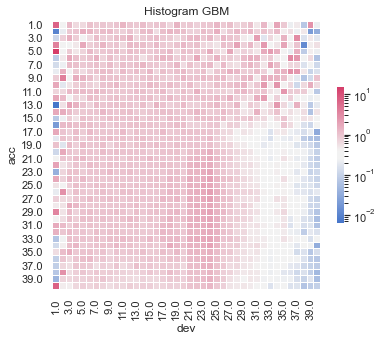

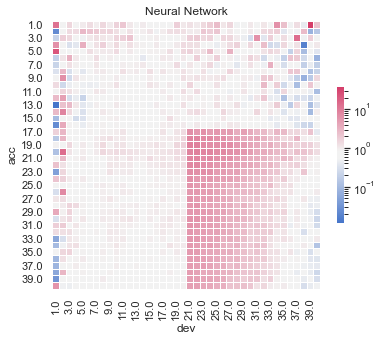

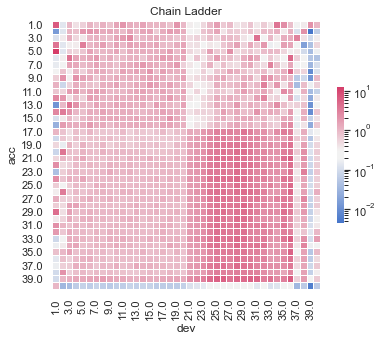

In [59]:
for name, y_pred in y_predicted_full_results.items():
    # Skip prev models - these are similar enough to last version
    if name not in ["LASSO (prev)", "Hist GBM (prev)"]: 

        # Plot
        dat_ = dat.copy() 
        dat_["pmts_ratio"] = dat_.pmts / y_pred
        
        cmap = sns.diverging_palette(255,0,sep=16, as_cmap=True)  # to be similar to R colouring
        
        plot_triangle(
            dat_.pivot(index="acc", columns="dev", values="pmts_ratio"),
            mask_bottom=False,
            title=name,
            cmap=cmap  # vlag also not a bad palette for this
        )

plt.show()

All models have shortcomings, but the LASSO and previously tuned XGBoost models outperform the others. 


### Quarterly tracking

Finally, we will look at the predictions for specific parts of the data set.
Quarterly tracking graphs:

* Plot the actual and fitted payments, including future values, by one of accident / development / calendar period
* Hold one of the other triangle directions fixed, meaning that the third direction is then determined.
* Additionally plot the underlying mean from which the data were simulated.

We'll use a couple of functions because we want to do this repeatedly.

The first function (`GraphModelVals`) is from the blog on the LASSO model, and draws a single tracking graph.
The second function (`QTracking`) generates the graphs for all models and uses the **patchwork** package to wrap them into a single plot.

Let's have a look at the tracking for accident quarter when development quarter = 5.
We'll wrap this in another function since we want to call this for a few different combinations.

In [60]:
model_names = [x["Name"] for x in scikit_results if name not in ["LASSO (prev)", "Hist GBM (prev)"]]

In [61]:
def QTrack(model_forecasts, model_names, period_to_filter, period, total_num_periods, plot_mu=True):
    """
    Plots model vs payments and mu
    
    Args:
    model_forecasts: Pandas DataFrame. Should have dev, acc, mu, pmts 
    model_names: List of model names to plot Should be columns in model_forecasts
    period_to_filter: "dev" or "acc". The period to filter by
    period: integer. filter value for period_to_filter. I.e. period_to_filter="acc", period=5 filters for acc=5.
    total_num_periods: total number of periods. First total_num_periods - period periods are greyed out.
    """
    fig, axs = plt.subplots(len(model_names), 1, sharex=True, figsize=(4, 1.8 * len(model_names)))
    
    other_period = [x for x in ["dev", "acc"] if x != period_to_filter][0]
    
    for model_name, ax in zip(model_names, axs):
        # Shade historical quarters
        ax.axvspan(0, total_num_periods - period, facecolor=plot_colors["lgrey"])
        
        # Plot mu
        if plot_mu:
            ax.plot(
            model_forecasts.loc[model_forecasts[period_to_filter] == period, other_period].values,
            np.log(model_forecasts.loc[model_forecasts[period_to_filter] == period, "mu"].values),
            color=plot_colors["dgrey"],
            linestyle=':')
        
        # Plot Payments
        ax.plot(
        model_forecasts.loc[model_forecasts[period_to_filter] == period, other_period].values, 
        np.log(model_forecasts.loc[model_forecasts[period_to_filter] == period, "pmts"].values), 
        color=plot_colors["dblue"])
        
        # Plot model
        ax.plot(
        model_forecasts.loc[model_forecasts[period_to_filter] == period, other_period].values, 
        np.log(model_forecasts.loc[model_forecasts[period_to_filter] == period, model_name].values), 
        color=plot_colors["red"],
        linewidth=6)
            
        ax.set_ylabel('Log(Payments)')
        ax.set_title(f'Modelled Values for {model_name}')
    
    if period_to_filter == "acc":
        ax.set_xlabel('Development Quarter')
    else:
        ax.set_xlabel('Accident Quarter')  
    
    plt.show()

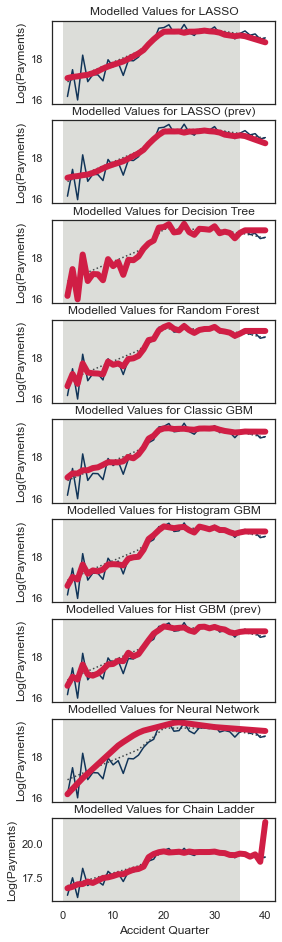

In [62]:
QTrack(model_forecasts, model_names, period_to_filter="dev", period=5, total_num_periods=num_periods)

Because this is mostly old data and because it is not affected by the interaction, the tracking should be generally good.

That being said, the predictions are a bit all over the place. 

The decision tree, random forest and classic GBM seem underfit, as does the neural network. The histogram GBM is decent, slightly overfit. The Chain Ladder final quarter is a bit wild as can happen with a Chain Ladder. The LASSO model is a bit rough - especially if compared to the fit from the R implementation - but isn't too bad.

Here are a few more tracking plots to help further illustrate the model fits.

**Tracking for accident quarter when development quarter = 24**

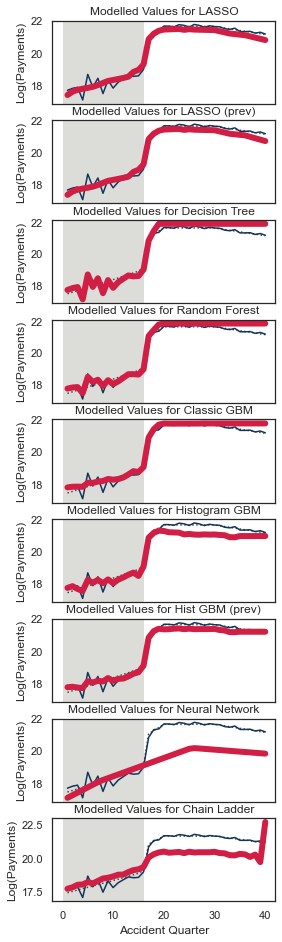

In [63]:
QTrack(model_forecasts, model_names, period_to_filter="dev", period=24, total_num_periods=num_periods)

Development quarter 24 is impacted by the interactions for accident quarters>17.

LASSO and the histogram GBM reflects this the best. The other tree models extrapolate a flat curve, whilst the neural network continues an upward trend. The Chain Ladder overpredicts the last value.

**Tracking for accident quarter when development quarter = 35**


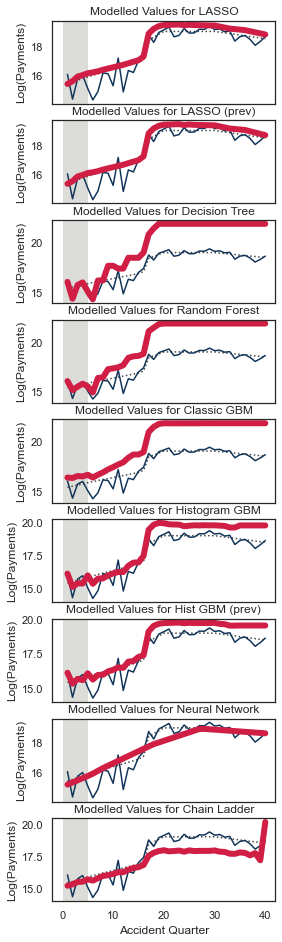

In [64]:
QTrack(model_forecasts, model_names, period_to_filter="dev", period=35, total_num_periods=num_periods)

This is quite hard for the models since most of the values are in the future. The neural network fits a smooth curve. The histogram GBM and the LASSO work well here. 

We can look at similar plots by development quarter for older and newer accident quarters

**Tracking for development quarter when accident quarter = 5**

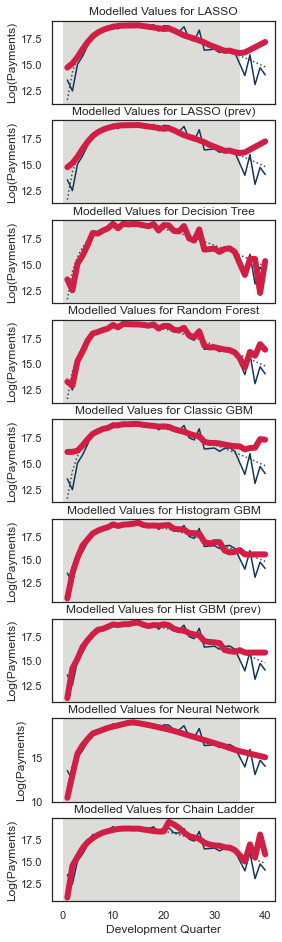

In [65]:
QTrack(model_forecasts, model_names, period_to_filter="acc", period=5, total_num_periods=num_periods)

The decision tree, random forest and classical GBM all project a flat line, but the others generally capture the downward trend.

**Tracking for development quarter when accident quarter = 20**

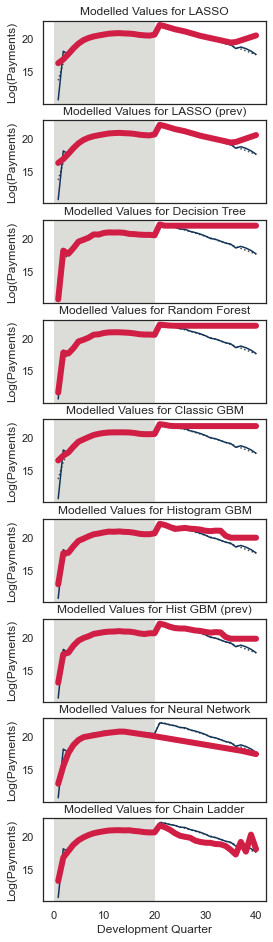

In [66]:
QTrack(model_forecasts, model_names, period_to_filter="acc", period=20, total_num_periods=num_periods)

Again, the LASSO, the histogram GBM, and neural network are all able to capture the trend.

# Reserves

Finally, we'll look at the reserve estimates from the different models:

<AxesSubplot:xlabel='acc'>

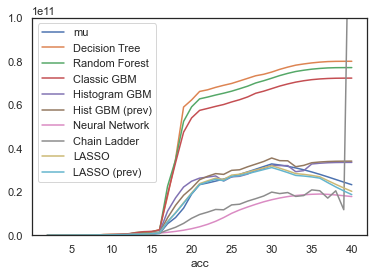

In [67]:
df_reserve_estimates = (
    model_forecasts
    .loc[model_forecasts.train_ind==False]
    .groupby("acc")
    .agg("sum")
    .drop(columns=["pmts", "accf", "devf", "dev", "cal", "train_ind"])
)

df_reserve_estimates.plot(ylim=(0, 1.0e11))

Finally, here are the overall reserves, summed over all accident quarters

In [68]:
df_reserve_summary= pd.DataFrame.from_dict({
    name: y_pred.sum() / 10**9
    for name, y_pred in y_predicted_test_results.items()},
    orient="index",
    columns=["Reserves ($B)"]
    )

df_reserve_summary["Ratio to actual(%)"] = (
    df_reserve_summary["Reserves ($B)"] / 
    y_predicted_test_results["Actuals"].sum() * 10**11
)

df_reserve_summary

,Reserves ($B),Ratio to actual(%)
Actuals,608,100
LASSO,596,98
LASSO (prev),579,95
Decision Tree,"1,678",276
Random Forest,"1,610",265
Classic GBM,"1,497",246
Histogram GBM,683,112
Hist GBM (prev),704,116
Neural Network,300,49
Chain Ladder,563,93


The overall reserve for the Chain Ladder model hides the fact that this result is actually significant under-estimation in most accident quarters balanced by significant over-estimation in the last.

The neural network seems to be underfit overall, whilst the flat line projections by the decision tree, random forest and classic GBM are too conservative.

Taking this into account, the best performers on this basis are the LASSO followed by the histogram GBM.

# Commentary

What's going on with the results? Can we improve matters?

Success in machine learning often comes down to optimising the following:

* What you model
* How you model (i.e. what features you use)
* Your performance measure
* Your train/test split.


## Models

**scikit-learn** is incredibly convenient in that it gives access to so many different models. The Python syntax is also quite clean and easy to use compared to R.

But we ran into some limitations:

 * The **sci-kit** GLM model didn't have all the features we needed. 

 * The classic GBM and Random Forest just performed poorly. 

 * The histogram GBM held up well well. There are many more customisable functionality if we were to use XGBoost, LightGBM or CatBoost, but the performance was similar to the two XGBoost models from the R version. 

 * Similarly the neural network is quite basic with the notable absence of the selection of activation functions. The target transform is a workaround but a full-featured package like **tensorflow** or **pytorch** may do better.


## Additional Features

More complex models such as GBMs and Neural Networks tend to perform better with bigger datasets. Our datasets in the example only include three factors - only two if you consider calendar quarter is just accident plus development. In real-world examples, you should be able to augment with additional rating factors or claims features to get a more predictive result.



## Tuning Method and Cross Validation
As we noted earlier, there are a few components of randomness from one run to another, with different seeds:

1. The cross validation folds will be different
2. The random search parameters will be different.

For a small data set like this one, this has the potential to alter the results - afterall, getting a good result on the future data depends on whether the tuning gets lucky in terms of estimating the magnitude of the interaction.

We could reduce the variability by using a grid-search over a fixed set of parameters but - full disclosure - that led to even worse results.

### So what's going on?
    It might be helpful to have another look at folds used in a cross-validation search.

These are shown below for six-fold CV - the yellow dots represent training data points in each fold, the blue dots are the test data. 
The grey rectangle marks the interaction. These are actually the folds used in the R article; the folds used here will be different in specifics, but the same general ideas hold.

![interaction compared to available triangle](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-07-mlr3example/index_files/figure-html/unnamed-chunk-65-1.png)

The first thing that is apparent is that the interaction only applies to a very small number of points (10) in the past data. So in that sense, it's quite remarkable that the models perform as well as they actually do - they all detect the interaction. Where they start to slip up is that they do not necessarily follow the development quarter shape in the tail.


### Finer fine-tuning

It should be noted that to cut down the run time of this example, we only tuned over 25 sets of parameters for each model, kept models coarse via less trees, less rounds, less neurons, higher learn rates, and used five-fold cross-validation. Performance can possibly be improved by tuning over more sets of parameters, bigger models, and higher fold count CV.

### Time-based hold-out testing

Reserving is a forecasting problem - we have a time series of payments and we want to forecast into the future.

This suggests that cross-validation may not be an ideal method for tuning reserving models - we would be better with a train/test split where the test data is in the future relative to the past data.

This problem has been discussed in the context of time series modelling, where the use of rolling window cross-validation techniques has been advocated. We'll be discussing this in a future article.



# Conclusion

We set out to demonstrate how to fit a number of reserving models to a data set.
Our results have been mixed - but we expected that in advance.
This work lays a baseline for our upcoming articles where we will look at ways of improving the results through:

* expanding the range of models
* considering more appropriate validation techniques.

## What next?

You can try running this code and changing some things - e.g. the hyper-parameters tuned, search strategy, number of iterations etc.

For those looking to use **scikit-learn**, it is worthwhile to read about some other limitations of the models [here](https://ryxcommar.com/2019/08/30/scikit-learns-defaults-are-wrong/).

You can also try other data sets as described in the [LASSO paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906)  by changing ``dataset_number`` near the start of the code. More details are in the paper, but in brief:

* Data set 1 = a Chain Ladder model
* Data set 2 = a Chain Ladder model + calendar period effects
* Data set 3 = the data set used here
* Data set 4 = data set 2 but where the strength of the calendar period effect varies by development period.

There will be more Python content coming out on the blog, so keep an eye out for further **developments**!
